## Imports

In [430]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Constantes

In [431]:
YEARS = 10
PI = np.pi
DELTA = 1/365

S0 = 5
K = 3
SIGMA = 1

GAMMA = 1
D0 = 0

### Modelo Molino

In [432]:
# modelo del molino
# Si+1 = Si + κ(θ(ti) −Si)∆ + σ√∆ Zi (1)
# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 


In [433]:
def trend(i):
    return 6 +  2* np.cos(2 * PI * i / 365)

def nextDay(i ,Si ,K ,sigma):
    return Si + K*(trend(i) - Si) * DELTA + sigma * DELTA**0.5 * np.random.normal(0,1)


def simulateTrip(days, k , sigma, S0 = 8):
    days = np.arange(0, 365 * YEARS, 1)
    shoks = np.random.normal(0, 1, len(days))
    trip = [S0]
    for i in days:
        Si = trip[-1]
        trip.append(nextDay(i,Si, k, sigma))
    return trip


In [434]:
# Diferencia entre molinos
#Di+1 = Di −βDi∆ + γ√∆ Wi (2)

def diffNextDay(dayi, beta, gamma):
    return dayi - beta * dayi * DELTA + gamma * DELTA**0.5 * np.random.normal(0,1)

def simulateDiffTrip():
    days = np.arange(0, 365 * YEARS, 1)
    trip = [D0]
    for i in days:
        trip.append(diffNextDay(trip[-1], K, SIGMA))
    return trip

In [435]:
def simulateTripNorteSUr():
    days = np.arange(0, 365 * YEARS, 1)
    tripNorte = np.array(simulateTrip())
    diff = np.array(simulateDiffTrip())
    tripSur = tripNorte + diff
    
    return tripNorte, tripSur

## Cargamos los datos

In [436]:
import pandas as pd

data = pd.read_excel("Wind data for TP1.xlsx")

data.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


In [437]:
# new column with the diff between one day and the previous one

data["diff_wind"] = data["regional wind"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_wind
0,1,8.000000,0.000000,0.346296
1,2,8.346296,0.181523,1.716019
2,3,10.062316,0.188643,0.729021
3,4,10.791337,0.071085,-0.037244
4,5,10.754093,0.078442,0.017364


## Regresion Lineal

In [438]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Supongamos que tienes los datos en un DataFrame
# df['S'] es la columna de la variable S
# df['theta'] es la columna de la variable θ(t)
# Δ es el tamaño de paso del tiempo

# Calcular las diferencias Y_i = S_{i+1} - S_i
data['diff_wind'] = data['regional wind'].diff().shift(-1)

# Calcular X1_i = (θ(t_i) - S_i) * Δ
data['X1'] = (trend(data["regional wind"][1:]) - data["regional wind"][:-1])* DELTA

# Calcular Z_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de Z_i, si no, deberás calcularla
# Z_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que Z_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X = data[['X1']][1:-1]
Y = data['diff_wind'][1:-1]
print("NULOS:  " + str( X.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X, Y)

# Obtener el valor de kappa (pendiente)
kappa = model.coef_[0]

# El valor de sigma puede necesitar un análisis adicional si lo deseas estimar explícitamente
# como sigma * sqrt(Δ). Esto puede derivarse a través de los residuos.

print(f"Valor estimado de kappa: {kappa}")


NULOS:  X1    0
dtype: int64
Valor estimado de kappa: 46.498371988177865


## Calculamos Sigma

In [439]:
# Calcular los residuos de la regresión
error = Y - model.predict(X)
var = error.var()
sigma = np.sqrt(var / DELTA)

print(f"Valor estimado de sigma: {sigma}")

Valor estimado de sigma: 16.84174843763948


## Graficos

In [440]:
kappa, sigma

(46.498371988177865, 16.84174843763948)

46.498371988177865 16.84174843763948


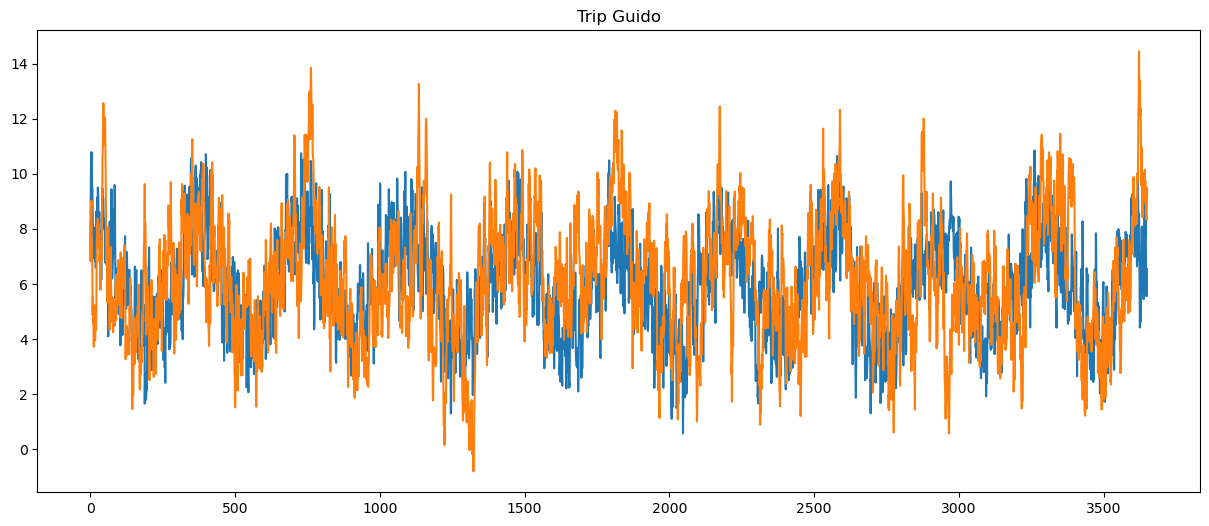

In [441]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['regional wind'])
plt.title("Trip Original")
# plt.show()

# graficar modelo predicgo
days = np.arange(0, 365 * YEARS, 1)

print(kappa, sigma)
trip_guido = simulateTrip(days, kappa, sigma,S0=8)
# plt.figure(figsize=(15, 6))
plt.plot(trip_guido)
plt.title("Trip Guido")
plt.show()




## Calculamos Beta y Gamma